
# Basic SIR model

This notebook explores the fundamentals of defining a differential equation as a function, then using Scipy's `solve_ivp` solver.

In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
from matplotlib import pyplot as plt
from matplotlib import rcParams

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

## Defining the differential equation as a function

We will define the differential equation

$$ \frac{dS}{dt} =    - \beta S I          $$
$$ \frac{dI}{dt} =    \beta S I - \gamma I $$
$$ \frac{dR}{dt} =    \gamma I             $$

as a Python function:

In [2]:
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

## Defining starting values

We define the following starting values:

In [3]:
S_0 = 1
I_0 = 0.0001
R_0 = 0

y_0 = (S_0, I_0, R_0)

R0 = 2.5
tau = 8
gamma = 1/tau
beta = R0 * gamma

In addition, we define the space $T = t_{0 \ldots n}$:

In [4]:
t = np.linspace(0, 100, 100)

## Solving with ODEINT

In [5]:
res = odeint(func=deriv, y0=y_0, t=t, args=(beta, gamma))

<ipython-input-6-0dabfcc6d583>:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


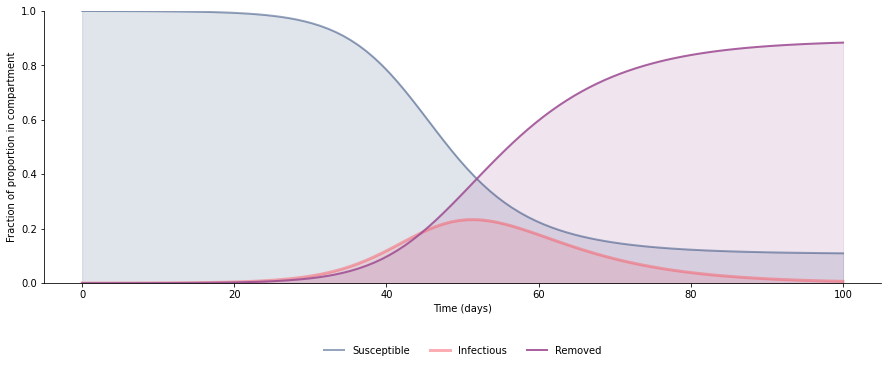

In [6]:
# We obtain each column by transposing then indexing (as Numpy indexes by default in rows)
S, I, R = res.T

ax.plot(t, S, color=COLORS["S"], alpha=0.5, lw=2, label="Susceptible")
ax.plot(t, I, color=COLORS["I"], alpha=0.5, lw=3, label="Infectious")
ax.plot(t, R, color=COLORS["R"], alpha=0.9, lw=2, label="Removed")

ax.fill_between(t, 0, S, color=COLORS["S"], alpha=0.15)
ax.fill_between(t, 0, I, color=COLORS["I"], alpha=0.15)
ax.fill_between(t, 0, R, color=COLORS["R"], alpha=0.15)

ax.set_xlabel('Time (days)')
ax.set_ylabel("Fraction of proportion in compartment")
ax.set_ylim(0, 1.0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)

fig.subplots_adjust(bottom=0.25)
plt.legend(title='', bbox_to_anchor=(0.5, -0.3), loc="lower center", ncol=3, frameon=False)

plt.savefig("sir_integral.pdf")
plt.show()

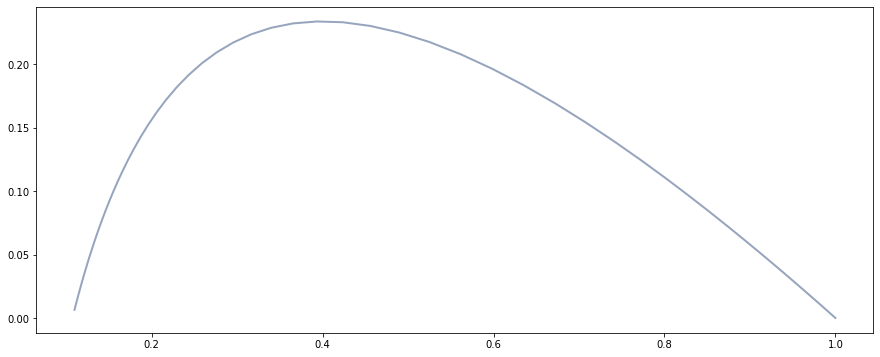

In [7]:
fig = plt.figure(facecolor="w", figsize=(15, 6))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(S, I, color=COLORS["S"], alpha=0.5, lw=2)

In [14]:
def integrate_for_i0(*i0_arr):
    result = []
    
    for each in i0_arr: 
        res = odeint(func=deriv, y0=(1 - each, each, 0), t=t, args=(beta, gamma)).T
        result.append([res[0], res[1]])

    return result

In [32]:
s = integrate_for_i0(*np.linspace(1e-5, 1e-1, 10).tolist())

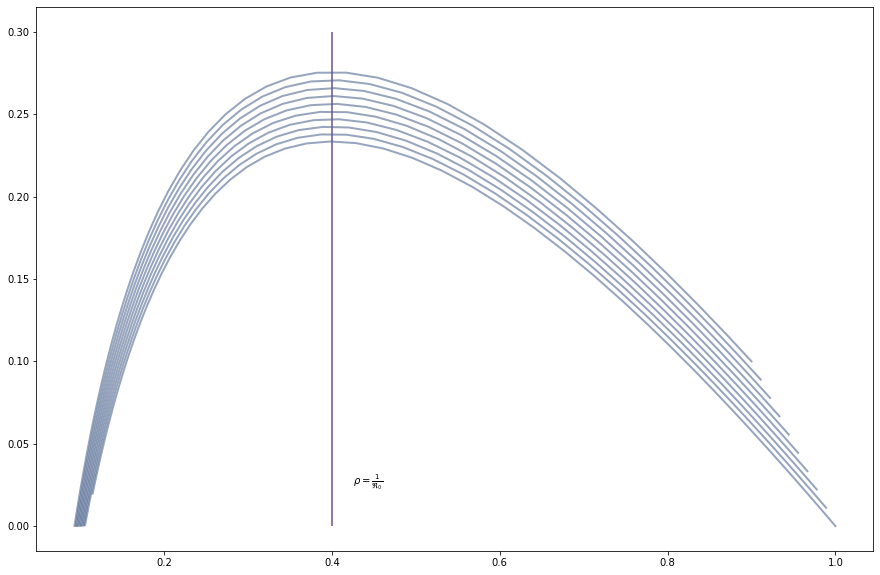

In [49]:
fig = plt.figure(facecolor="w", figsize=(15, 10))
ax = fig.add_subplot(111, axisbelow=True)
for each in s:
    ax.plot(each[0], each[1], color=COLORS["S"], alpha=0.5, lw=2)

ax.vlines(x=1/R0, ymin=0, ymax=0.3, color=COLORS["X"])
ax.annotate("$\\rho = \\frac{1}{\\mathfrak{R}_0}$", xy = (0.425,0.025))

plt.savefig("characteristic_curves.pdf")

In [13]:
s

{1e-06: [array([0.999999  , 0.99999865, 0.99999823, 0.99999772, 0.9999971 ,
         0.99999636, 0.99999546, 0.99999437, 0.99999305, 0.99999146,
         0.99998954, 0.99998721, 0.99998441, 0.99998101, 0.99997691,
         0.99997195, 0.99996595, 0.99995871, 0.99994996, 0.99993937,
         0.99992658, 0.99991112, 0.99989244, 0.99986987, 0.99984259,
         0.99980962, 0.99976979, 0.99972165, 0.99966345, 0.99959318,
         0.99950827, 0.99940569, 0.99928174, 0.99913199, 0.9989511 ,
         0.99873261, 0.99846873, 0.99815009, 0.99776537, 0.99730094,
         0.99674044, 0.99606418, 0.99524855, 0.99426522, 0.9930803 ,
         0.99165332, 0.98993608, 0.98787135, 0.98539138, 0.98241642,
         0.97885303, 0.9745925 , 0.96950936, 0.96346031, 0.95628364,
         0.94779979, 0.93781315, 0.92611593, 0.91249463, 0.89673937,
         0.8786567 , 0.85808579, 0.8349171 , 0.80911242, 0.78072371,
         0.74990775, 0.71693336, 0.68217825, 0.64611418, 0.60928084,
         0.57225128, 0.5355

## Solving with `solve_ivp`

The `solve_ivp` API differs in a number of significant ways from the `odeint` API:

* `solve_ivp` function definitions of ODEs are ordered as `(t, y, *args)` rather than `(y, t, *args)` - i.e. the point of evaluation comes first
* `solve_ivp` does not require the integration interval to be specified as an iterable - the argument `t_span` is simply a tuple of minimum and maximum values

Equally, the result is returned in a rather different way:

* calling the result itself returns a verbose output
* calling `.t` on the result provides the points at which integration was performed
* calling `.y` provides the values - in this case, as a tuple of tuples that will not have to be transposed 

In [5]:
I_0 = 0.0001
S_0 = 1 - I_0
R_0 = 0

y_0 = (S_0, I_0, R_0)

R0 = 2.5
tau = 8
gamma = 1/tau
beta = R0 * gamma

In [6]:
def deriv(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [7]:
res = solve_ivp(fun=deriv, t_span = (0, 100), y0=y_0, args=(beta, gamma), max_step=1)

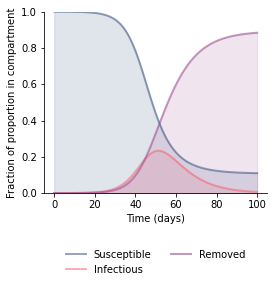

In [57]:
S, I, R = res.y


fig = plt.figure(facecolor="w", figsize=(4, 4))
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(res.t, S, color=COLORS["S"], alpha=0.5, lw=2, label="Susceptible")
ax.plot(res.t, I, color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")
ax.plot(res.t, R, color=COLORS["R"], alpha = 0.6, lw=2, label="Removed")

ax.fill_between(res.t, 0, S, color=COLORS["S"], alpha=0.15)
ax.fill_between(res.t, 0, I, color=COLORS["I"], alpha=0.15)
ax.fill_between(res.t, 0, R, color=COLORS["R"], alpha=0.15)

ax.set_xlabel('Time (days)')
ax.set_ylabel("Fraction of proportion in compartment")
ax.set_ylim(0, 1.0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.5), loc="lower center", ncol=2, frameon=False)

fig.subplots_adjust(bottom=0.25)

plt.savefig("sir_integral_small.pdf")
plt.show()

In [58]:
type(res)

scipy.integrate._ivp.ivp.OdeResult

# Epidemic curves as a function of $\tau$ and $R_0$

In [59]:
R_0_range = [2, 3, 4, 5, 7.5, 10]
tau_range = [7, 10, 14, 21]

epicurves = {}

for i in R_0_range:
    epicurves[i] = {}
    for j in tau_range:
        epicurves[i][j] = []

In [60]:
for i in R_0_range:
    for j in tau_range:
        gamma = 1/j
        beta = i * gamma
        res = solve_ivp(fun=deriv, t_span = (0, 100), y0=y_0, args=(beta, gamma), max_step=1)
        epicurves[i][j] = [t, res.y[1], res.y[0], res.y[2]]


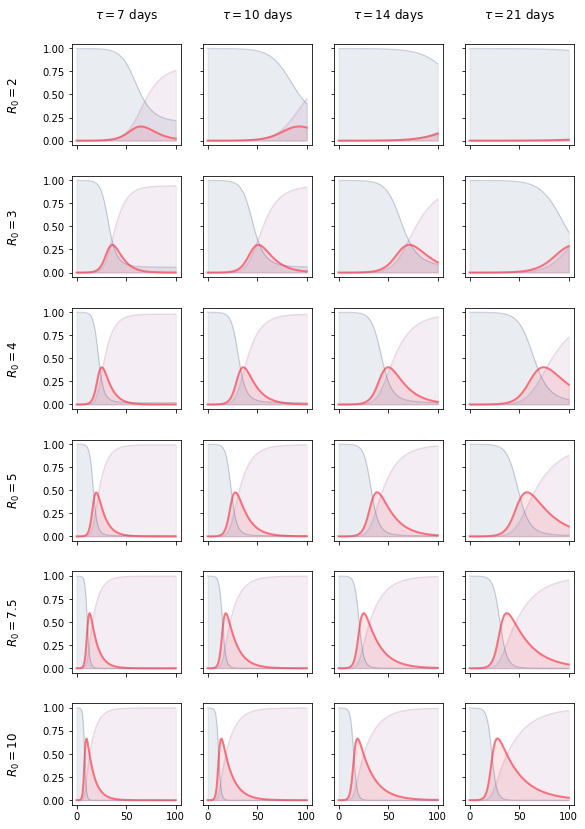

In [72]:
fig, axs = plt.subplots(len(R_0_range), len(tau_range), sharex=True, sharey=True, figsize=(1.5*len(R_0_range), 3.5*len(tau_range)))

for iidx, ival in enumerate(R_0_range):
    for jidx, jval in enumerate(tau_range):
        axs[iidx][jidx].plot(epicurves[ival][jval][0], epicurves[ival][jval][1][:100], color=COLORS["I"], alpha=0.85, lw=2)
        axs[iidx][jidx].fill_between(epicurves[ival][jval][0], 0, epicurves[ival][jval][1][:100], color=COLORS["I"], alpha=0.15)
        axs[iidx][jidx].plot(epicurves[ival][jval][0], epicurves[ival][jval][2][:100], color=COLORS["S"], alpha=0.2, lw=1)
        axs[iidx][jidx].fill_between(epicurves[ival][jval][0], 0, epicurves[ival][jval][2][:100], color=COLORS["S"], alpha=0.1)
        axs[iidx][jidx].plot(epicurves[ival][jval][0], epicurves[ival][jval][3][:100], color=COLORS["R"], alpha=0.2, lw=1)
        axs[iidx][jidx].fill_between(epicurves[ival][jval][0], 0, epicurves[ival][jval][3][:100], color=COLORS["R"], alpha=0.1)

cols = [r"$\tau = {} $ days".format(col) for col in tau_range]
rows = [r"$R_0 = {}$".format(row) for row in R_0_range]

for ax, col in zip(axs[0], cols):
    ax.set_title(col, pad=25)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size="large", labelpad=20)

fig.subplots_adjust(hspace=0.3)

plt.savefig("tau_r0_matrix.pdf")